In [1]:
import sys
sys.path.append('..')

from data.tile_stitcher import stitch_predictions
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
# ckpt = '2410/Hagen-joint_indi-l1/36'
# ckpt = '2502/Hagen-joint_indi-l1/57'
# ckpt  = '2412/HT_LIF-joint_indi-l1/8'
# ckpt = '2501/COSEM_jrc-hela-joint_indi-l1/32'
# ckpt = '2502/COSEM_jrc-hela-joint_indi-l1/13'
# ckpt = '2502/HT_LIF24-joint_indi-l1/60'
ckpt = '2502/HT_LIF24-joint_indi-l1/60'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_epochs_normalization = 5
ckpt_time_predictor = None#'2502/Hagen-UnetClassifier-l2/8' #'2502/Hagen-UnetClassifier-l2/3'#None #'2502/Hagen-UnetClassifier-l2/0'
time_predictor = None
# mixing_t_ood = 0.2
mmse_count = 1

num_timesteps = 1
enable_real_input = True
infer_time = False
use_aggregated_inferred_time = False
use_hardcoded_time_for_inference = 0.5


ckpt = ckpt.strip('/').strip(' ')
ckpt

'2502/HT_LIF24-joint_indi-l1/60'

In [3]:
if use_aggregated_inferred_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for aggregated time inference'
    assert use_hardcoded_time_for_inference is use_hardcoded_time_for_inference, 'Hardcoded time inference is not supported with aggregated time inference'
    assert infer_time is True, 'Time inference must be enabled for aggregated time inference'


if infer_time:
    assert ckpt_time_predictor is not None, 'Time predictor is required for time inference'

if use_hardcoded_time_for_inference is not None:
    assert not infer_time, 'Time inference must be disabled for hardcoded time inference'

assert enable_real_input is True, 'Synthetic input is not supported in this notebook.'


In [4]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        # best_files = [f for f in list_of_files if 'best_gen_' in f]
        # assert len(best_files) == 1,f'{best_files}'
        # best_file = best_files[0]  
        fname = latest_file
        return os.path.join(ckpt_dir,fname)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [5]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os
import torch

if ckpt_time_predictor is not None:
    time_pred_ckpt_fpath = os.path.join(training_rootdir, ckpt_time_predictor)

    time_pred_opt = load_config(time_pred_ckpt_fpath)
    time_pred_model_opt = time_pred_opt['model']
    time_predictor = TimePredictor(
        in_channel=time_pred_model_opt['unet']['in_channel'],
        out_channel=time_pred_model_opt['unet']['out_channel'],
        norm_groups=time_pred_model_opt['unet']['norm_groups'],
        inner_channel=time_pred_model_opt['unet']['inner_channel'],
        channel_mults=time_pred_model_opt['unet']['channel_multiplier'],
        attn_res=time_pred_model_opt['unet']['attn_res'],
        res_blocks=time_pred_model_opt['unet']['res_blocks'],
        dropout=time_pred_model_opt['unet']['dropout'],
        image_size=time_pred_opt['datasets']['patch_size'],
        )
    
    time_predictor = time_predictor.cuda()
    time_predictor.load_state_dict(torch.load(os.path.join(time_pred_ckpt_fpath,'best_time_predictor.pth')), strict=True)
    time_predictor.eval()
    print('Loaded time predictor from', time_pred_ckpt_fpath)


In [6]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
# opt['path']['resume_state'] = os.path.join(os.path.dirname(opt['path']['resume_state']),'I110000_E1375')
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('val_jrc_hela','test_jrc_hela')

elif opt['datasets']['train']['name'] == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }
elif opt['datasets']['train']['name'] in ['HT_LIF24','HT_LIF']:
    opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val','/test')


/group/jug/ashesh/training/diffsplit/2502/HT_LIF24-joint_indi-l1/60/checkpoint/I450000_E4412


In [7]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if enable_real_input:
    opt['datasets']['train']['real_input_fraction'] = 1.0
    opt['datasets']['val']['real_input_fraction'] = 1.0

opt['datasets']['normalize_channels'] = False

In [8]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

Loading data from /group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/train/train_500ms_Ch_B-Ch_D-Ch_BD.tif
Using first 90/90 for real input
Computing mean and std for normalization
[SplitDataset] Data: 90x3x(1608, 1608) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False RealFraction:1.0 InpFrmNormTar
Loading data from /group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/test/test_500ms_Ch_B-Ch_D-Ch_BD.tif
Using first 10/10 for real input
[TilingDataset] Data: 10x3x(1608, 1608) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False RealFraction:1.0 InpFrmNormTar
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[JointIndi]: w_input_loss: 0.1 
Scheduler set to ReduceLROnPlateau with patience:  100

--------------------------------------------------
Number of trainable parameters: 4.88M
--------------------------------------------------



In [9]:
data_dict = val_set[0]

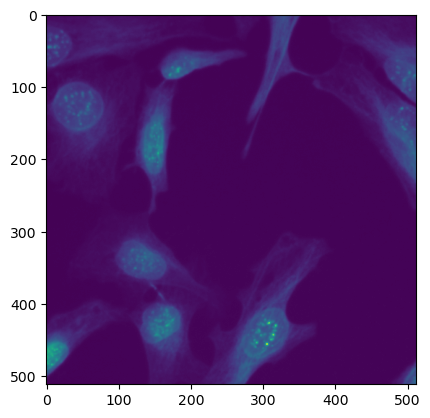

In [10]:

plt.imshow(data_dict['input'][0])

In [11]:
from model.normalizer import NormalizerXT
import numpy as np

def get_real_input_normalizer(train_set, train_opt, num_epochs=1, dummy=False):
    xt_normalizer1 = NormalizerXT(num_bins=1)
    if dummy:
        print('--------Dummy Normalizer Activated--------')
        return None, None #xt_normalizer1, xt_normalizer2
    
    from tqdm import tqdm
    for _ in range(num_epochs):
        train_loader = Data.create_dataloader(train_set, train_opt, 'train')
        bar = tqdm(train_loader)
        idx = 0
        for data in bar:
            idx +=1
            ch_inp = data['input'].cuda()
            t_float_arr = torch.Tensor(np.random.rand(ch_inp.shape[0])).cuda()
            xt_normalizer1.normalize(ch_inp, t_float_arr, update=True)
            # if idx > 100:
            #     break
    return xt_normalizer1


In [12]:
val_set.set_random_patching(True)
xt_normalizer= get_real_input_normalizer(val_set,opt['datasets']['train'], 
                                                   num_epochs=num_epochs_normalization)
val_set.set_random_patching(False)

Random patching set to True


  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:00<00:00, 58.35it/s]

Random patching set to False


In [13]:
import numpy as np
import random

# def get_input_dict(data_dict):
#     inp = data_dict['input'].cuda()
#     # t does not matter since it is a real input.
#     diffusion_data = {'input': xt_normalizer.normalize(inp, torch.Tensor([0.9]*len(inp)), update=False), 
#                       'target': data_dict['target'].cuda()}

        
    # return diffusion_data

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# norm_dict = val_set.get_input_target_normalization_dict()
# nimgs = 6
# dloader = torch.utils.data.DataLoader(
#             val_set,
#             batch_size=nimgs,
#             shuffle=True,
#             num_workers=0,
#             pin_memory=True)
# for batch_data in dloader:
#     break

# # diffusion_batch_input = get_input_dict(batch_data)

In [15]:
def get_prediction(data_dict, infer_time=True):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict, infer_time=infer_time)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict, infer_time=True):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4
    t_float_start = 0.5
    if time_predictor is not None and infer_time:
        t_float_start = time_predictor(data_dict['input'].cuda())
        
    # NOTE: infer_time=False must be set for recent models.
    prediction = diffusion.netG.inference(data_dict['input'], infer_time=False, t_float_start=t_float_start).detach().cpu().numpy()
    input = data_dict['input'].cpu().numpy()
    target = data_dict['target'].cpu().numpy()

    
    # unnormalize 
    assert len(prediction.shape) == 4
    pred_unnorm = prediction * norm_dict['std_target'] + norm_dict['mean_target']
    target_unnorm = target * norm_dict['std_target'] + norm_dict['mean_target']
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [16]:
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')


In [17]:
import seaborn as sns
# show_hist = False
# if show_hist:
#     ncols = predictions.shape[-1]
#     _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
#     for ch_idx in range(ncols):
#         sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
#         sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
#     plt.legend()
#     plt.tight_layout()

## Quantitative Evaluation using the classifier.
Here, we also inspect the effect of MMSE count.

In [18]:

if time_predictor is not None:
    t_pred1 = []
    t_pred2 = []
    with torch.no_grad():
        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
            inp_indi2 = data['target'][:1]*mixing_t_ood + data['target'][1:2]*(1-mixing_t_ood)
            inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
            inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
            # we can use mixing_t_ood for the normalization, because if it is real image, then we anyway have to normalize it separately.
            norm_inp1 = xt_normalizer1.normalize(inp_indi1.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi1)).cuda(), update=False)
            norm_inp2 = xt_normalizer2.normalize(inp_indi2.cuda(), torch.Tensor([mixing_t_ood]*len(inp_indi2)).cuda(), update=False)
            
            # time predictor notion of time is 1 - t, This formulation ensures that we have the time corresponding to indi1.
            t1 = 1 - time_predictor(norm_inp1)
            t2 = 1 - time_predictor(norm_inp2)
            t_pred1.append(t1.item())
            t_pred2.append(t2.item())

    t_pred1_aggregated = np.mean(t_pred1) 
    t_pred2_aggregated = np.mean(t_pred2)
    print(t_pred1_aggregated, t_pred2_aggregated)
else:
    t_pred1_aggregated = None
    t_pred2_aggregated = None

In [19]:
len(val_set._data_dict[2])

10

In [20]:
# use_aggregated_inferred_time = False
# use_hardcoded_time_for_inference = 0.5
# infer_time = False

In [21]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm
import numpy as np

def sanitize_t(t_val, eps = 1e-6):
    t_val = np.clip(t_val, 0+eps, 1-eps)
    return t_val

print('infer_time', infer_time, 'use_aggregated_inferred_time', use_aggregated_inferred_time, 'use_hardcoded_time_for_inference', use_hardcoded_time_for_inference)
indi_model = diffusion.netG
psnr_dict_ood = defaultdict(list)
all_targets_ood = []
all_inputs_ood = []
eps = 1e-6

pred_t_1_arr = []
mmse_pred_arr = []
with torch.no_grad():
    for mmse_idx in range(mmse_count):
        all_predictions = []

        for i in tqdm(range(len(val_set))):
            data = val_set[i]
            norm_inp = xt_normalizer.normalize(torch.Tensor(data['input'][None]).cuda(), torch.Tensor([0.9]).cuda(), update=False)


            # picking the time
            if infer_time:
                if use_aggregated_inferred_time:
                    predt_inp = t_pred1_aggregated
                else:
                    assert use_hardcoded_time_for_inference is None, 'Hardcoded time inference is not supported with individual time inference'
                    predt_inp = 1 - time_predictor(norm_inp).item()
            elif use_hardcoded_time_for_inference is not None:
                predt_inp = use_hardcoded_time_for_inference
            else:
                raise ValueError('Invalid time inference configuration. We donot know the GT mixing')

            predt_inp = sanitize_t(predt_inp)




            ch1_pred = indi_model.indi1.inference(norm_inp, num_timesteps=1, t_float_start=predt_inp)
            ch2_pred = indi_model.indi2.inference(norm_inp,  num_timesteps=1, t_float_start=1-predt_inp)

            if mmse_idx == 0:
                all_inputs_ood.append(norm_inp.cpu().numpy())
            pred_t_1_arr.append(predt_inp)

            
            pred_ = np.concatenate([ch1_pred.cpu().numpy(), ch2_pred.cpu().numpy()], axis=1)
            
            tar_unnorm = data['target']
            if mmse_idx == 0:
                all_targets_ood.append(tar_unnorm[None])
            
            all_predictions.append(pred_)

        all_predictions = np.concatenate(all_predictions, axis=0)
        mmse_pred_arr.append(all_predictions)
    
all_targets_ood = np.concatenate(all_targets_ood, axis=0)
all_inputs_ood = np.concatenate(all_inputs_ood, axis=0)

pred_t_1_arr = np.array(pred_t_1_arr)


infer_time False use_aggregated_inferred_time False use_hardcoded_time_for_inference 0.5


  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 360/360 [00:18<00:00, 19.64it/s]


In [22]:
mmse_pred = 0 
for i in range(mmse_count):
    mmse_pred += mmse_pred_arr[i]/mmse_count

In [23]:
from data.tile_stitcher import stitch_predictions

pred_stitched = stitch_predictions(mmse_pred, val_set.tile_manager)
tar_stitched = stitch_predictions(all_targets_ood, val_set.tile_manager)
inputs_stitched_ood = stitch_predictions(all_inputs_ood, val_set.tile_manager)

mean_val = train_set.normalization_dict['mean_channel'][:2]
std_val = train_set.normalization_dict['std_channel'][:2]

pred_stitched = pred_stitched*std_val + mean_val

[10, 1608, 1608, 2]
[10, 1608, 1608, 2]
[10, 1608, 1608, 1]


In [24]:
pred_stitched[0,...,1].max(), pred_stitched[0,...,1].min(), tar_stitched[0,...,1].max(), tar_stitched[0,...,1].min()

(7660.5335496282205, 156.09451994389383, 12383.0, 142.0)

In [25]:
# from metrics import RangeInvariantPsnr
# bt_rem = RangeInvariantPsnr(tar_stitched[...,0], pred_bt_removed_stitched[...,0]).mean().item(), RangeInvariantPsnr(tar_stitched[...,1], pred_bt_removed_stitched[...,1]).mean().item()
# dim_pred = RangeInvariantPsnr(tar_stitched[...,0], pred_dim_pred_stitched[...,0]).mean().item(), RangeInvariantPsnr(tar_stitched[...,1], pred_dim_pred_stitched[...,1]).mean().item()
# print('BT removed', bt_rem)
# print('Dim pred', dim_pred)

In [26]:
from metrics import compute_stats
bt_removed_stats_dict = compute_stats(tar_stitched, pred_stitched)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 10/10 [00:00<00:00, 10.74it/s]


PSNR:	 39.23+-0.725	42.89+-0.686
MicroSSIM:	 0.981+-0.002	0.979+-0.005
MicroS3IM:	 0.991+-0.001	0.993+-0.001
SSIM:	 0.983+-0.002	0.986+-0.001
MSSSIM:	 0.991+-0.001	0.991+-0.001
lpips:	 0.011+-0.001	0.019+-0.001


In [28]:
def ssim_str(ssim_tmp):
    return f"{np.round(ssim_tmp[0], 3):.3f}+-{np.round(ssim_tmp[1], 3):.4f}"

def psnr_str(psnr_tmp):
    return f"{np.round(psnr_tmp[0], 2)}+-{np.round(psnr_tmp[1], 3)}"

def print_stats_dict(stats_dict, prefix=''):
    print(
        prefix, "PSNR:\t", "\t".join([psnr_str(psnr_tmp) for psnr_tmp in stats_dict['rangeinvpsnr']])
    )
    print(
        prefix, "MicroSSIM:\t",
        "\t".join([ssim_str(ssim) for ssim in stats_dict['microssim']]),
    )
    print(
        prefix, "MicroS3IM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['ms3im']])
    )
    print(prefix, "SSIM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['ssim']]))
    print(prefix, "MSSSIM:\t", "\t".join([ssim_str(ssim) for ssim in stats_dict['msssim']]))
    # lpiips
    print(prefix, "lpips:\t", "\t".join([ssim_str(lpips) for lpips in stats_dict['lpips']]))

print('Ckpt:',ckpt)

if ckpt_time_predictor is not None:
    print('Classifier:',ckpt_time_predictor)

infer_time, 'use_aggregated_inferred_time', use_aggregated_inferred_time, 'use_hardcoded_time_for_inference', use_hardcoded_time_for_inference

msg  = f'T:{num_timesteps} RealInp:{enable_real_input} M:{mmse_count} TPred:{infer_time} TPredAgg:{use_aggregated_inferred_time}'
msg += f' TPredFixed:{use_hardcoded_time_for_inference}'

msg += f'Norm:{num_epochs_normalization} InfSteps:{num_timesteps}\n'

print(msg)
print_stats_dict(bt_removed_stats_dict, '')

Ckpt: 2502/HT_LIF24-joint_indi-l1/60
T:1 RealInp:True M:1 TPred:False TPredAgg:False TPredFixed:0.5Norm:5 InfSteps:1

 PSNR:	 39.23+-0.725	42.89+-0.686
 MicroSSIM:	 0.981+-0.0020	0.979+-0.0050
 MicroS3IM:	 0.991+-0.0010	0.993+-0.0010
 SSIM:	 0.983+-0.0020	0.986+-0.0010
 MSSSIM:	 0.991+-0.0010	0.991+-0.0010
 lpips:	 0.011+-0.0010	0.019+-0.0010


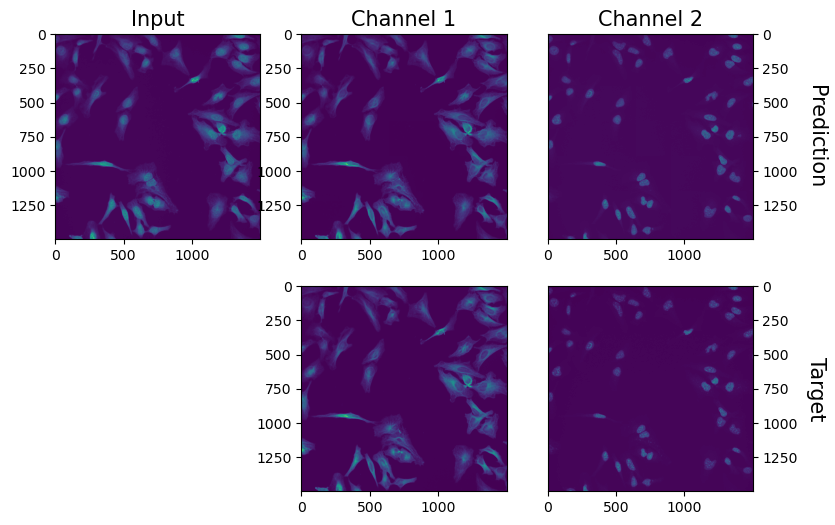

In [29]:
import matplotlib.pyplot as plt

_,ax = plt.subplots(figsize=(9,6),ncols=3,nrows=2)
img_idx = 0
hs = 0 
ws = 0
sz = 1500
# inputs
ax[0,0].set_title(f'Input', fontsize=15)
ax[0,0].imshow(inputs_stitched_ood[img_idx,hs:hs+sz,ws:ws+sz,0])

#  ch1 predictions
ax[0,1].set_title('Channel 1', fontsize=15)
ax[0,1].imshow(pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
# ax[1,1].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])

# ch2 predictions
ax[0,2].set_title('Channel 2', fontsize=15)
ax[0,2].imshow(pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
# set ylabel on the right side of the plot
ax[0,2].set_ylabel('Prediction', fontsize=15, rotation=270, labelpad=20)
ax[0,2].yaxis.set_label_position("right")
ax[0,2].yaxis.tick_right()

# ax[1,2].imshow(pred_dim_pred_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])

# ax[0,0].set_ylabel('BT Removed', fontsize=15)
# ax[1,0].set_ylabel('Weak Signal Pred', fontsize=15)

# target
ax[1,0].axis('off')
ax[1,1].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,0])
ax[1,2].imshow(tar_stitched[img_idx,hs:hs+sz,ws:ws+sz,1])
# ax[1,1].set_ylabel('Target', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15, rotation=270, labelpad=20)
ax[1,2].yaxis.set_label_position("right")
ax[1,2].yaxis.tick_right()


## Saving the predictions

In [30]:
param_str = f"MMSE-{mmse_count}_InferT-{int(infer_time)}_InferTAgg-{int(use_aggregated_inferred_time)}_FixedT-{use_hardcoded_time_for_inference}"
result_dir = os.path.join('/group/jug/ashesh/indiSplit/', 'predictions',param_str)
os.makedirs(result_dir, exist_ok=True)
print(result_dir)

/group/jug/ashesh/indiSplit/predictions/MMSE-1_InferT-0_InferTAgg-0_FixedT-0.5


In [31]:
from skimage.io import imread, imsave
def save_tiff(path, data):
    imsave(path, data, plugin='tifffile')


save_tiff(os.path.join(result_dir,'pred.tif'), pred_stitched)
pred_stitched.shape

(10, 1608, 1608, 2)